# Support Vector Machine

### Binary Classification

Scikit-learn's `SVC` takes as input two arrays: an array $X$ of shape $(n_samples, n_features)$, and an array $y$ of labels of shape $(n_samples)$.

In [3]:
from sklearn import svm
X = [[0, 0], [1, 1], [1, 0], [0, 1]]
y = [0, 1, 1, 0]
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X, y)

SVC(kernel='linear')

After being trained, the model can be used to predict new values:

In [4]:
clf.predict([[2., 2.], [0., 0.]])

array([1, 0])

SVMs decision function depends on some subset of the training data, called the support vectors. Some properties of these support vectors can be found in attributes `support_vectors_`, `support_` and `n_support_`:

In [5]:
# Get support vectors
sv = clf.support_vectors_
print("Support Vectors: ", sv)
# Get indices of support vectors
sv_indices = clf.support_
print("Indices of Support Vectors: ", sv_indices)
# Get number of support vectors for each class
n_sv = clf.n_support_
print("Number of Support Vectors for each class: ", n_sv)

Support Vectors:  [[0. 0.]
 [0. 1.]
 [1. 1.]
 [1. 0.]]
Indices of Support Vectors:  [0 3 1 2]
Number of Support Vectors for each class:  [2 2]


## Maximum margin separating hyperplane

Plot the maximum margin separating hyperplane within a two-class separable dataset using a Support Vector Machine classifier with linear kernel

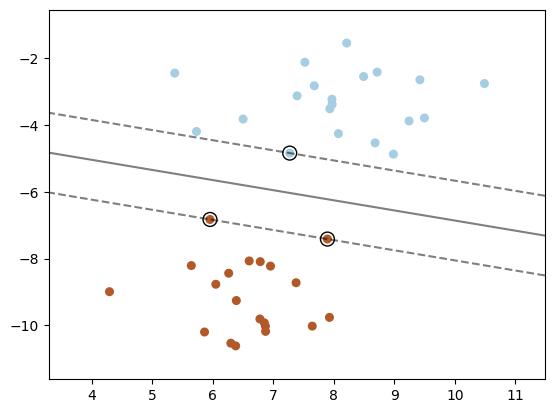

In [6]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

# Create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)
# Fit the model
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# Plot the decision boundary
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    ax=ax,
    alpha=0.5,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    facecolors="none",
    edgecolors="k",
)
plt.show()

### Anova

The following example shows how to perform univariate feature selection before running a SVC to improve the classification scores. We use the iris dataset (4 features) and add 36 non-informative features. We can find that our model achieves best performance when we select around 10% of features.

In [7]:
# Load the iris dataset
import numpy as np
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

# Add noise to the dataset
rng = np.random.RandomState(42)
X = np.hstack((X, 2 * rng.random((X.shape[0], 36))))

In [8]:
# Create the pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Create a pipeline with feature selection transformation, scaling, and SVC
pipeline = Pipeline(
    [
        ("anova", SelectPercentile(f_classif)),
        ("scaler", StandardScaler()),
        ("svc", SVC(gamma="auto")),
    ]
)

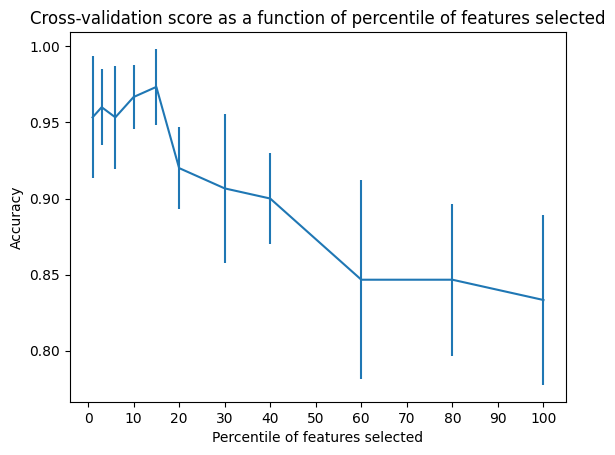

In [9]:
# Plot the cross-validation scores as a function of the percentile of features selected
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score

score_means = []
score_stds = []
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    pipeline.set_params(anova__percentile=percentile)
    scores = cross_val_score(pipeline, X, y)
    score_means.append(scores.mean())
    score_stds.append(scores.std())

plt.errorbar(
    percentiles,
    score_means,
    np.array(score_stds),
)
plt.title("Cross-validation score as a function of percentile of features selected")
plt.xlabel("Percentile of features selected")
plt.ylabel("Accuracy")
plt.axis("tight")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.show()

## Multi-class classification

SVC and NuSVC implement the “one-versus-one” approach for multi-class classification. In total, n_classes * (n_classes - 1) / 2 classifiers are constructed and each one trains data from two classes. To provide a consistent interface with other classifiers, the decision_function_shape option allows to monotonically transform the results of the “one-versus-one” classifiers to a “one-vs-rest” decision function of shape (n_samples, n_classes), which is the default setting of the parameter (default=’ovr’).

In [10]:
X = [[0], [1], [2], [3]]
y = [0, 1, 2, 3]
clf = svm.SVC(decision_function_shape="ovo")
clf.fit(X, y)


SVC(decision_function_shape='ovo')

In [11]:
dec = clf.decision_function([[1]])
dec.shape[1]

6

In [12]:
clf.decision_function_shape = "ovr"
dec = clf.decision_function([[1]])
dec.shape[1]

4

On the other hand, LinearSVC implements “one-vs-the-rest” multi-class strategy, thus training n_classes models.

In [13]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X, y)

LinearSVC()

In [14]:
dec = lin_clf.decision_function([[1]])
dec.shape[1]

4

### Plot different SVM classifiers in the iris dataset

Comparison of different linear SVM classifiers on a 2D projection of the iris dataset. We only consider the first 2 features of this dataset:

- Sepal length
- Sepal width

This example shows how to plot the decision surface for four SVM classifiers with different kernels.

The linear models LinearSVC() and SVC(kernel='linear') yield slightly different decision boundaries. This can be a consequence of the following differences:

LinearSVC minimizes the squared hinge loss while SVC minimizes the regular hinge loss.

LinearSVC uses the One-vs-All (also known as One-vs-Rest) multiclass reduction while SVC uses the One-vs-One multiclass reduction.

Both linear models have linear decision boundaries (intersecting hyperplanes) while the non-linear kernel models (polynomial or Gaussian RBF) have more flexible non-linear decision boundaries with shapes that depend on the kind of kernel and its parameters.

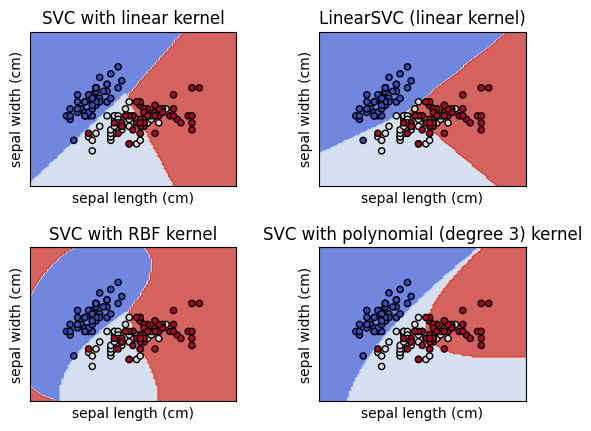

In [15]:
import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.inspection import DecisionBoundaryDisplay

# Load the iris dataset
iris = datasets.load_iris()
# Take the first two features
X = iris.data[:, :2]
y = iris.target
# Create a collection of SVM classifiers
C = 1.0 # SVM regularization parameter
models = [
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", C=C, gamma=0.7),
    svm.SVC(kernel="poly", C=C, degree=3, gamma="auto"),
]
# fit the models
for model in models:
    model.fit(X, y)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

### Handle Unbalanced classes

Find the optimal separating hyperplane using an SVC for classes that are unbalanced.

We first find the separating plane with a plain SVC and then plot (dashed) the separating hyperplane with automatically correction for unbalanced classes.

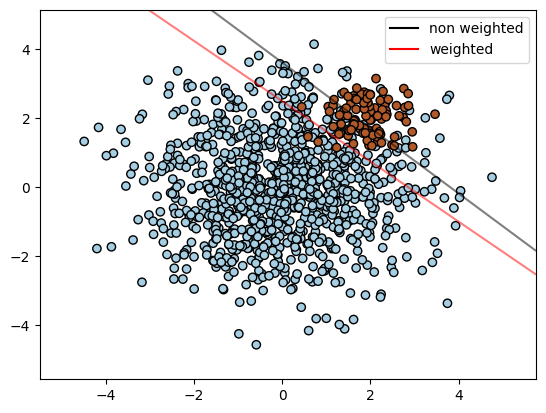

In [16]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

# Create two unbalanced classes of points
n_samples_0 = 1000
n_samples_1 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(
    n_samples=[n_samples_0, n_samples_1], 
    centers=centers, 
    cluster_std=clusters_std,
    random_state=0,
    shuffle=False,
)
# Fit the model
clf = svm.SVC(kernel="linear", C=1.0)
clf.fit(X, y)

# fit the model with weighted classes
wclf = svm.SVC(kernel="linear", C=1.0, class_weight={1: 10})
wclf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired)

# plot the decision functions for both classifiers
ax = plt.gca()
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
    ax=ax,
)

# plot decision boundary and margins for weighted classes
wdisp = DecisionBoundaryDisplay.from_estimator(
    wclf,
    X,
    plot_method="contour",
    colors="r",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
    ax=ax,
)

plt.legend(
    [
        mlines.Line2D([], [], color="k", label="non weighted"),
        mlines.Line2D([], [], color="r", label="weighted"),
    ],
    ["non weighted", "weighted"],
    loc="upper right",
)
plt.show()

Plot decision function of a weighted dataset, where the size of points is proportional to its weight.

The sample weighting rescales the C parameter, which means that the classifier puts more emphasis on getting these points right. The effect might often be subtle. To emphasize the effect here, we particularly weight outliers, making the deformation of the decision boundary very visible.



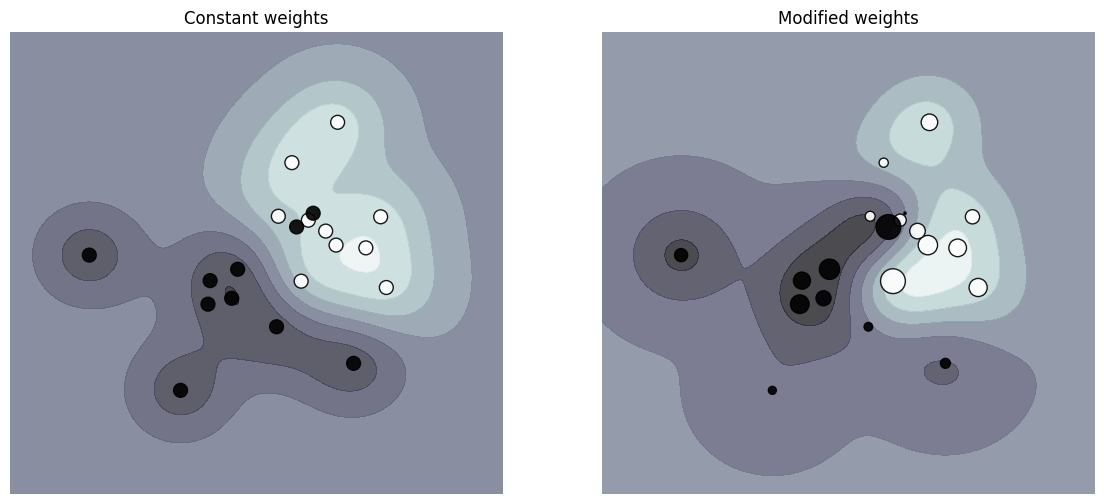

In [17]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm


def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        s=100 * sample_weight,
        alpha=0.9,
        cmap=plt.cm.bone,
        edgecolors="black",
    )

    axis.axis("off")
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# Fit the models.

# This model does not take into account sample weights.
clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

# This other model takes into account some dedicated sample weights.
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(
    clf_no_weights, sample_weight_constant, axes[0], "Constant weights"
)
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1], "Modified weights")

plt.show()